# Self-Driving Car Engineer Nanodegree

## Project: Build a Traffic Sign Recognition Classifier

## Step 0: Load The Data

In [73]:
import cv2
import csv
import time
import glob
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from skimage import color

plt.gray()

label_names = []
reader = csv.DictReader(open('signnames.csv'))
for row in reader:
    label_names.append(row['SignName'])

training_file = "traffic-signs-data/train.p"
validation_file="traffic-signs-data/valid.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_original, y_train_original = train['features'], train['labels']
X_valid_original, y_valid_original = valid['features'], valid['labels']
X_test_original, y_test_original = test['features'], test['labels']

## Step 1: Dataset Summary & Exploration

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [63]:
n_train = len(X_train_original)
n_validation = len(X_valid_original)
n_test = len(X_test_original)
image_shape = X_test_original[0].shape
n_classes = len(np.unique(y_train_original))
img_size=X_train_original.shape[1]
image_depth_channels = image_shape[2]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

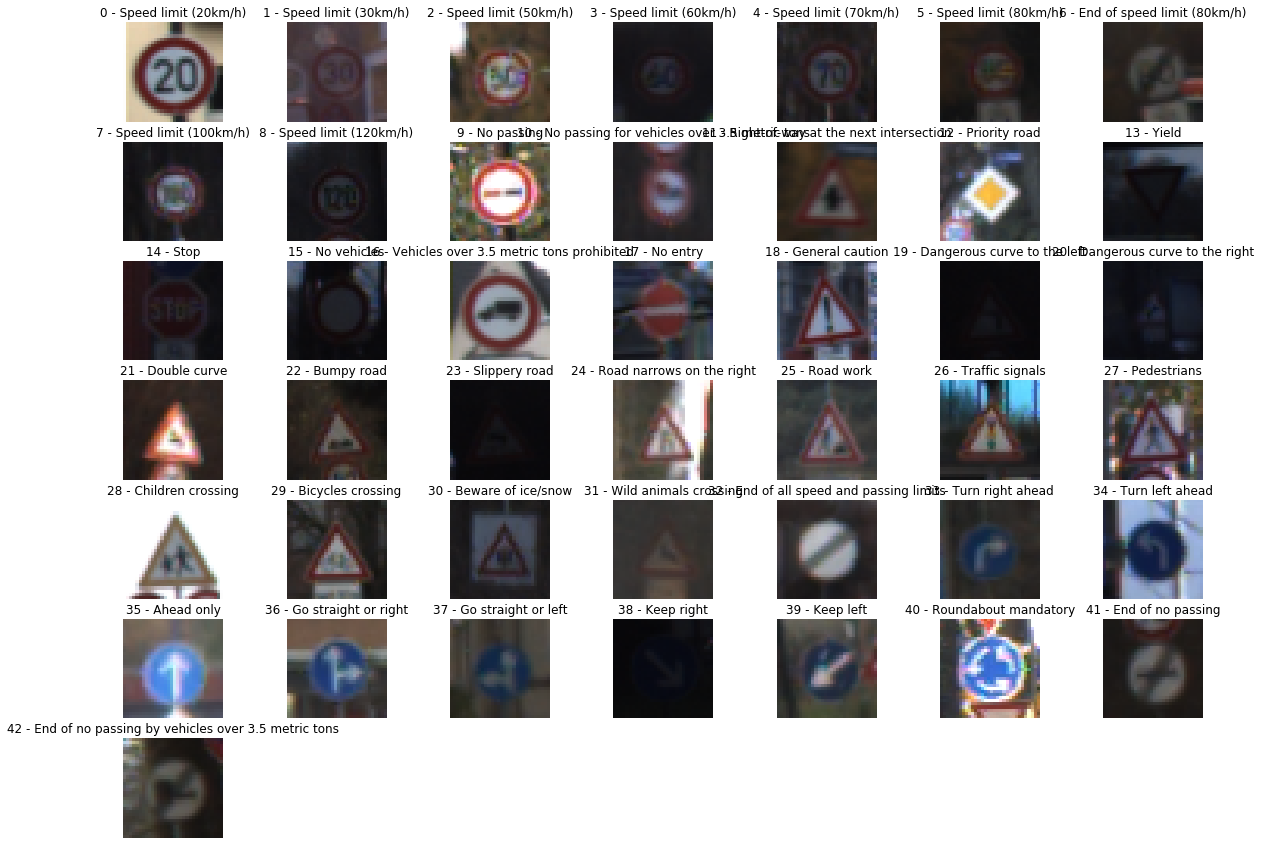

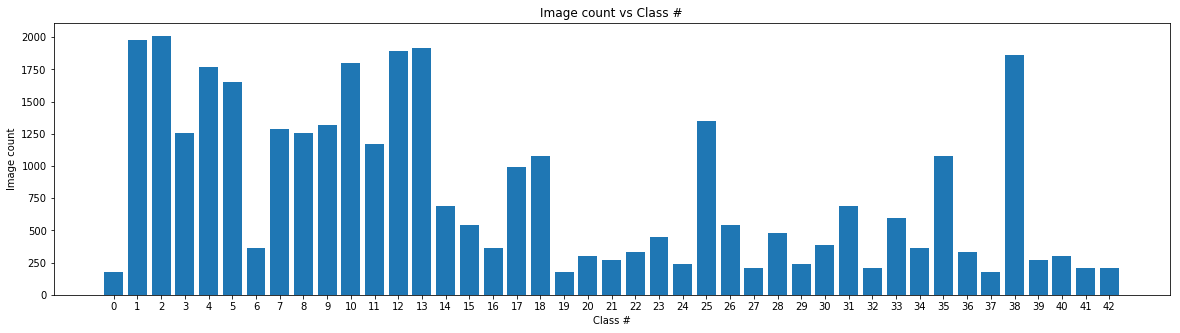

In [64]:
# Plot label classes along with a sample image
label_count=[]
plt.figure(figsize=(20, 15))
for i in range(0, n_classes):
    plt.subplot(7, 7, i + 1)
    x_selected = X_train_original[y_train_original == i]
    plt.imshow(x_selected[0, :, :, :])
    plt.title(str(i)  + " - " + label_names[i])
    plt.axis('off')
    label_count.append(len(x_selected))
plt.show()

# Plot number of images per class
plt.figure(figsize=(20, 5))
plt.bar(range(0, n_classes), label_count)
plt.title("Image count vs Class #")
plt.xlabel("Class #")
plt.ylabel("Image count")
plt.xticks(np.arange(0, n_classes, 1))
plt.show()


----

## Step 2: Design and Test a Model Architecture
To meet specifications, the validation set accuracy will need to be at least 0.93.


### Augment the Data Set

In [65]:
def augment_brightness_image(image):
    image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image = np.array(image, dtype = np.float64)
    random_bright = .5+np.random.uniform()
    image[:,:,2] = image[:,:,2]*random_bright
    image[:,:,2][image[:,:,2]>255]  = 255
    image = np.array(image, dtype = np.uint8)
    image = cv2.cvtColor(image,cv2.COLOR_HSV2RGB)
    return image

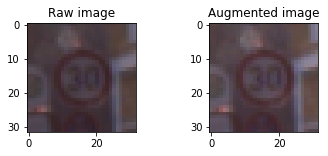

In [66]:
# Display augmentation result
img_original = X_train_original[y_train_original == 1][0,:,:,:]
img_augmented = augment_brightness_image(img_original)
plt.figure(figsize=(6, 2))

plt.subplot(1, 2, 1)
plt.imshow(img_original)
plt.title("Raw image")

plt.subplot(1, 2, 2)
plt.imshow(img_augmented)
plt.title("Augmented image")

plt.show()

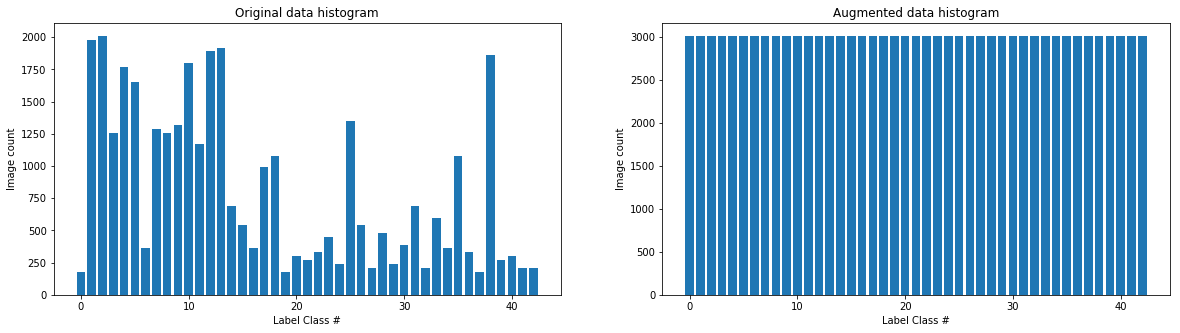

In [68]:
# Plot number of images per class

X_train_aug = X_train_original
y_train_aug = y_train_original

X_valid_aug = X_valid_original
y_valid_aug = y_valid_original

X_test_aug = X_test_original
y_test_aug = y_test_original

X_train_extra = []
y_train_extra = []

label_orig_count = []
label_aug_count = []

for i in range(0, n_classes):
    x_selected = X_train_original[y_train_original == i]
    label_orig_count.append(len(x_selected))
    
max_label_count = max(label_orig_count)
target_label_count = max_label_count * 1.5
    
for i in range(0, n_classes):
    x_selected = X_train_original[y_train_original == i]
    current_count = len(x_selected)    
    batch_size = int(target_label_count / current_count)
        
    for j in range(0, current_count):
            
        for k in range(0, batch_size):
            if current_count >= target_label_count:
                break
                
            current_count += 1
            
            X_train_extra.append(augment_brightness_image(X_train_original[0]))
            y_train_extra.append(i)
        
        
    label_aug_count.append(current_count)

X_train_extra = np.array(X_train_extra)
y_train_extra = np.array(y_train_extra)

X_train_aug = np.concatenate((X_train_aug, X_train_extra), axis=0)
y_train_aug = np.concatenate((y_train_aug, y_train_extra), axis=0)

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.xlabel("Label Class #")
plt.ylabel("Image count")
plt.bar(range(0, n_classes), label_orig_count)
plt.title("Original data histogram")

plt.subplot(1, 2, 2)
plt.xlabel("Label Class #")
plt.ylabel("Image count")
plt.bar(range(0, n_classes), label_aug_count)
plt.title("Augmented data histogram")
plt.show()


### Pre-process the Data Set

In [70]:
def gray(img):
    return np.sum(img/3, axis = 3, keepdims=True)

def normalize(img):
    return img/127.5-1

def preprocess(img):
    return normalize(gray(img))

# Greyscale, then normalize
image_depth_channels = 1

X_train_processed = preprocess(X_train_aug)
y_train_processed = y_train_aug

X_test_processed = preprocess(X_test_aug)
y_test_processed = y_test_aug

X_valid_processed = preprocess(X_valid_aug)
y_valid_processed = y_valid_aug

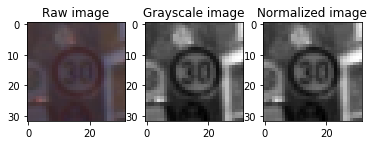

In [74]:
# Display preprocessing results
img_original = X_train_aug[y_train_aug == 1][0,:,:,:]
img_gray = gray(X_train_aug)[y_train_aug == 1][0,:,:,:].squeeze()
img_normal = preprocess(X_train_aug)[y_train_aug == 1][0,:,:,:].squeeze()

plt.figure(figsize=(6, 2))

plt.subplot(1, 3, 1)
plt.imshow(img_original)
plt.title("Raw image")

plt.subplot(1, 3, 2)
plt.imshow(img_gray)
plt.title("Grayscale image")

plt.subplot(1, 3, 3)
plt.imshow(img_normal)
plt.title("Normalized image")

plt.show()

# Model Architecture

In [77]:
EPOCHS = 1
BATCH_SIZE = 128
RATE = 0.001
dropout = 0.5
keep_prob = tf.placeholder(tf.float32)
x = tf.placeholder(tf.float32, (None, 32, 32, image_depth_channels))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

In [121]:
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Convolutional
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, image_depth_channels, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Convolutional
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten
    fc0   = flatten(conv2)
    
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1    = tf.nn.relu(fc1)

    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    fc2    = tf.nn.relu(fc2)

    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

In [81]:
X_train = X_train_processed
y_train = y_train_processed

X_valid = X_valid_processed
y_valid = y_valid_processed

X_test = X_test_processed
y_test = y_test_processed

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = RATE)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [82]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    validation_accuracy_list = []
    test_accuracy_list = []
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
         
        validation_accuracy = evaluate(X_valid, y_valid)
        validation_accuracy_list.append(validation_accuracy)
        
        test_accuracy = evaluate(X_test, y_test)
        test_accuracy_list.append(test_accuracy)
        
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.838

Model saved


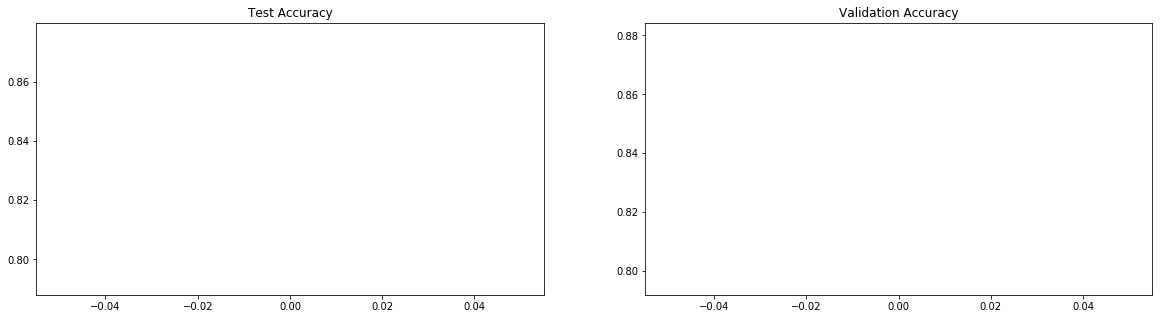

In [85]:
# Plot accuracy
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(test_accuracy_list)
plt.title("Test Accuracy")

plt.subplot(1, 2, 2)
plt.plot(validation_accuracy_list)
plt.title("Validation Accuracy")

plt.show()

In [88]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.834


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

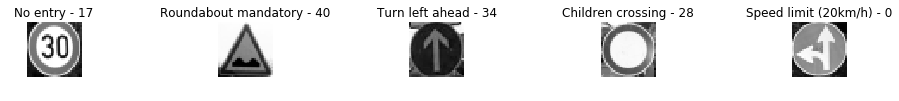

In [126]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import glob
import cv2

sample_images_files = sorted(glob.glob('./extra-signs-2/*.png'))
sample_labels = np.array([1, 22, 35, 13, 37])
sample_images = []
sample_count = len(sample_images_files)
index = 0
for image_file in sample_images_files:
    sample_images.append(cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB))

X_test_data = preprocess(np.array(sample_images))

plt.figure(figsize=(20, 1))

for i in range(0, sample_count):
    plt.subplot(1, sample_count + 1, i + 1)
    plt.imshow(X_test_data[i].squeeze())
    plt.title(label_names[sample_labels[i]] + " - " + str(sample_labels[i]))
    plt.axis('off')

plt.show()


### Predict the Sign Type for Each Image

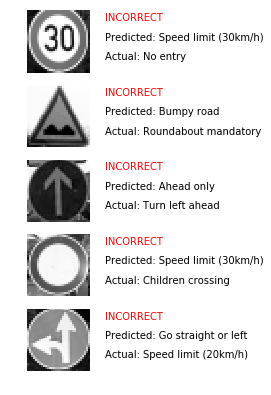

In [127]:
def test_net(X_data, sess):
    pred_sign = sess.run(tf.argmax(logits, 1), feed_dict={x: X_data, keep_prob: 1.0})
    return pred_sign
   
with tf.Session() as sess:
    saver.restore(sess, './lenet')
    signs_classes=test_net(X_test_data, sess)
    
plt.figure(figsize=(10, 8))

for i in range(0, sample_count):
    plt.subplot(sample_count + 1, 1, i + 1)
    plt.axis('off')
    is_correct = sample_labels[i] == signs_classes[i]
    
    plt.imshow(X_test_data[i].squeeze())
    plt.text(40.0, 5.0, "CORRECT" if is_correct else "INCORRECT", color='green' if is_correct else 'red')
    plt.text(40.0, 15.0, "Predicted: " + label_names[signs_classes[i]])
    plt.text(40.0, 25.0, "Actual: " + label_names[sample_labels[i]])

plt.show()



### Analyze Performance

In [132]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

print("Accuracy")

with tf.Session() as sess:
    saver.restore(sess, "./lenet")
    my_accuracy = evaluate(X_test_data, sample_labels)
    print("Test Set Accuracy = {:.3f}".format(my_accuracy))

print("Done")

Accuracy
Test Set Accuracy = 0.000
Done


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

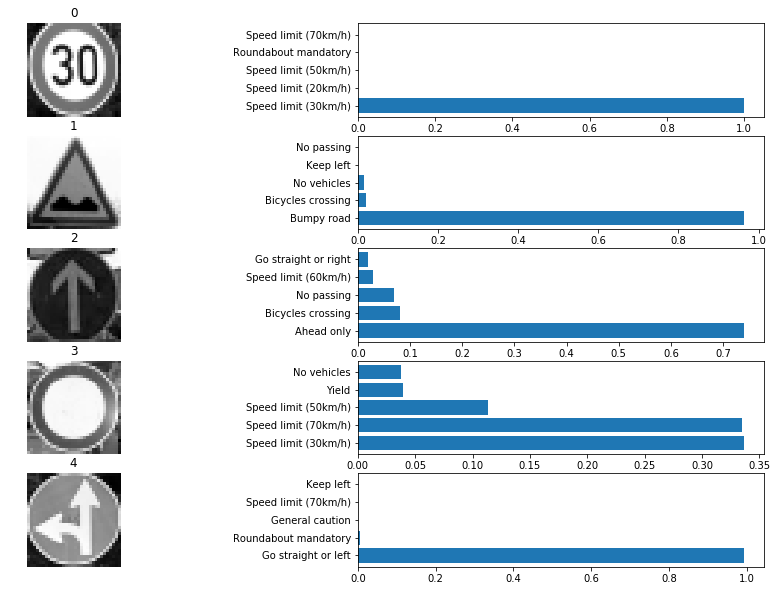

In [130]:
def top_5(X_data, sess):
    prob = sess.run(tf.nn.softmax(logits), feed_dict={x: X_data, keep_prob: 1.0})    
    top_5 = tf.nn.top_k(prob, k=5)
    return sess.run(top_5)

with tf.Session() as sess:
    saver.restore(sess, './lenet')
    signs_top_5=top_5(X_test_data, sess)
    
plt.figure(figsize=(16, 10))
for i in range(0, sample_count):
    plt.subplot(sample_count, 2, 2*i+1)
    plt.imshow(X_test_data[i].squeeze()) 
    plt.title(i)
    plt.axis('off')
    plt.subplot(sample_count, 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), signs_top_5.values[i, :])
    labs=[label_names[j] for j in signs_top_5.indices[i]]
    plt.yticks(np.arange(1, 6, 1), labs)
plt.show()